In [1]:
## INSTALL DEPENDENT LIBRARIES


!pip install tqdm --quiet
!pip install pandas --quiet
#workhorse for converting text into embeddings/vectors
!pip install sentence-transformers==2.2.2 --quiet
#data framework for LLM applications
!pip install llama-index==0.9.6.post1 --quiet
#logging output
!pip install loguru==0.7.0 --quiet
#convenient pretty printing library
!pip install rich==13.7.0 --quiet
#openai Tokenizer library
!pip install tiktoken --quiet

In [2]:
#standard libraries
import json
import os
import time
from collections import defaultdict
from typing import List, Dict, Tuple, Union, Callable
from math import ceil

#external libraries
import pandas as pd
import numpy as np
from rich import print
from torch import cuda
from tqdm.notebook import tqdm

#external files
from preprocessing import FileIO

 ## Step 1 -->  Import YouTube/Podcast Transcripts
***
### The Data
The data - **384** podcast episodes to be exact - we will use for this project is a collection of transcribed podcast/youtube episodes of <a href="https://www.youtube.com/@TomBilyeu" target="_blank">The Impact Theory</a>.  From the About section of Impact Theory:
<h4 ><em>"Impact Theory™ is a weekly interview show that explores the mindsets of the world's highest achievers to learn their secrets to success.</em></h4>
<h4 ><em>Hosted by Quest Nutrition co-founder Tom Bilyeu, Impact Theory is designed to give people the tools and knowledge they need to unlock their potential and impact the world."</em></h4>
<br>
 The episodes for this course were pulled from the podcast audio files and transcribed using the OpenAI open source [Whisper model](https://github.com/openai/whisper).  The transcriptions were then linked back to each episode using a unique **video_id**. 



In [3]:
root_folder = 'data/'
data_file = 'impact_theory_data.json'
data_path = os.path.join(root_folder, data_file)

with open(data_path) as f:
    data =  json.load(f)
print(f'Total # of episodes: {len(data)}')

Total # of episodes: 384

In [4]:
data_path

'data/impact_theory_data.json'

In [5]:
# uncomment the following line to see data for first entry, it's big
# data[0]

In [6]:
# Seeing truncated data and field names
my_fields = []
for key, value in data[0].items() :
    my_fields.append(key)

print (my_fields)
print ("content : {}".format(data[0]['content'][0:600]))

[
    'title',
    'video_id',
    'playlist_id',
    'length',
    'thumbnail_url',
    'views',
    'episode_url',
    'guest',
    'summary',
    'content'
]

content : You said these are dangerous times. The world order is shifting before our eyes. We also both know that 
with hyper disruptive technologies like AI on the horizon, a good outcome is not guaranteed. Why do you think big 
tech will become the third superpower and what are the dangers and opportunities if it does? Big tech is 
essentially sovereign over the digital world. The fact that former President Trump was de-platformed from Facebook 
and from Twitter when he was president, you know, most powerful political figure on the planet. And he's just taken
off of those networks and as a consequence, hu

### Metadata Glossary
- **title**: Episode title.
- **video_id**: Unique identifier for each individual episode.
- **playlist_id**: Unique identifier for entire playlist of episodes.  All episodes in this dataset will have the same playlist_id.
- **length**: Length of the episode in total seconds.
- **thumbnail_url**: Hyperlink to the associated image of the YouTube episode.
- **views**: Number of views of this YouTube episode.
- **episode_url**: Hyperlink to the episode on YouTube.
- **guest**: Main guest for the episode.
- **summary**: Summary of the episode (AI generated).
- **content**: The full transcript of the episode.

In [7]:
#content length stats
contents = [d['content'] for d in data]
content_lengths = [len(content.split()) for content in contents]
df = pd.DataFrame(content_lengths, columns=['# Words'])
df.describe()

,# Words
count,384.000000
mean,12821.268229
std,7650.847177
min,1819.000000
25%,7888.000000
50%,9894.500000
75%,16857.000000
max,48502.000000


### Tokens
In the above example we split our content on whitespace which effectively splits the entire episode into a list of words....but LLMs operate on tokens. Tokens are words or sub-parts of words, so the word "texting" might be broken into two tokens `text` and `##ing`. Punctuation are also given their own tokens, so a period, a comma, or an apostropher are all going to have their own tokenized versions.  A [750 word document will be about 1000 tokens](https://www.anyscale.com/blog/num-every-llm-developer-should-know), in other words the token to word ratio is roughly 1.3 tokens = 1 word. Let's see what this looks like in practice.

In [8]:
mean_word_count = ceil(np.mean(content_lengths))
token_to_word_ratio = 1.3
approx_token_count = ceil(mean_word_count * token_to_word_ratio)
print(f'The mean word count for each episode is about {mean_word_count} words, which corresponds to a rough token count of {approx_token_count} tokens.')

The mean word count for each episode is about 12822 words, which corresponds to a rough token count of 16669 
tokens.

For the sake of precision, let's actually tokenize our content and see how close we get to the **1.3** `token_to_word_ratio`.  We'll use the tokenizer for the `gpt-3.5-turbo-0613` LLM (avilable through the `tikotken` library).

In [9]:
import tiktoken # Awesome tokenizer library for use with OpenAI LLMs

#instantiate tokenizer for use with ChatGPT-3.5-Turbo
encoding = tiktoken.encoding_for_model('gpt-3.5-turbo-0613')

tokens = encoding.encode_batch(contents)
token_counts = list(map(len, tokens))
token_df = pd.DataFrame(token_counts, columns=['# Tokens'])
token_df.describe()

,# Tokens
count,384.000000
mean,15516.523438
std,9380.049480
min,2210.000000
25%,9523.750000
50%,12007.500000
75%,20268.000000
max,61559.000000


In [10]:
#How close to this approximate 1.3 token:word ratio were we
true_ratio = round(np.mean(token_counts)/mean_word_count, 2)
true_ratio

1.21

In [11]:
#Let's get one more metric, let's see how big (in tokens) the size of our total corpus is:
total_tokens = sum(token_counts)
print(f'Total Tokens in Corpus: {total_tokens}')

Total Tokens in Corpus: 5958345

6 million tokens is no small matter, it's roughly equivalent to 10,000 pages of text, but to put things in perspective the Falcon-40B LLM was trained on a [1 trillion token](https://synthedia.substack.com/p/falcon-40b-llm-trained-on-1-trillion) corpus, which is 167,000 times larger than the one we are currently using! 🤯

Embedding Tokens vs. LLM Tokens (i.e. Retriever vs. Reader):

We know that as part of our system we want to feed relevant context to an OpenAI LLM.  All LLMs, even the largest ones, have a limited input context window, so we'll have to take that into consideration as part of our system design.  But before we even get to that point, we have to first consider the maximum input sequence (in tokens) for our emebdding model.  Given that the mean token count for each of our podcast episodes is over 15K tokens, we'll need a way to chunk our content so that we can effectively embed the transcript into several meaningful embeddings as opposed to one embedding for the entire transcript. Let's address how we'll accomplish that task.

## Step 2 -->  Sentence Splitting and Chunking
***

### Chunking:
The open source embedding models that we will be working with have a `max_sequence_length` parameter far less than 15K tokens. In fact, the embedding model that we'll use: [`all-miniLM-L6-v2`](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2), has a default max input length of 256 tokens. In order to effectively process the content of our podcast episodes, we'll need to decide on a **Chunking Strategy**.

1. Gather documents.  In our case we're considering a single Impact Theory episode to be a "document".
2. Decide how to split your documents.  When working with text documents, a good starting strategy is to split on sentence boundaries.  This decision at the very least, prevents input text from randomly being cut off in the middle of a paragraph.  We'll use an excellent piece of code written by [LlamaIndex](https://github.com/run-llama/llama_index/blob/main/llama_index/node_parser/text/sentence.py) namely, the `SentenceSplitter` class.
3. Pick a chunk size based on your use case.  Given that the `all-miniLM-L6-v2` was trained on documents no greater than 256 tokens in length, we'll start with 256.  A chunk size of 256 strikes a good balance between information granularity and not blowing up the embedding space.
4. After splitting, a single episode will be broken up into `n` number of chunks, depending on the length of the episode.  Each of those chunks, however, should be no longer than 256 tokens.  Those chunks can then be passed through our embedding model as inputs and converted into vector representations.
5. The final step is combining the text chunks, their associated vectors, and the original metadata into a single dictionary (one for each chunk), in preparation for follow-on indexing on our Weaviate datastore.

In [12]:
from llama_index.text_splitter import SentenceSplitter #one of the best on the market

#set chunk size and instantiate your SentenceSplitter
chunk_size = 256
gpt35_txt_splitter = SentenceSplitter(chunk_size=chunk_size, tokenizer=encoding.encode, chunk_overlap=0)

In [13]:
def split_contents(corpus: List[dict],
                   text_splitter: SentenceSplitter,
                   content_field: str='content'
                   ) -> List[List[str]]:

    corpus_chunk_list = []
    for episode in corpus:
      output = text_splitter.split_text(episode[content_field])
      corpus_chunk_list.append(output)
    
    return corpus_chunk_list

content_splits = split_contents(data, gpt35_txt_splitter)

In [14]:
print (len(content_splits))
print (len(content_splits[0]))

384

83

In [15]:
import unittest
from unitesting_utils import load_impact_theory_data

class TestSplitContents(unittest.TestCase):
    '''
    Unit test to ensure proper functionality of split_contents function
    '''

    def test_split_contents(self):
        import tiktoken
        from llama_index.text_splitter import SentenceSplitter

        data = load_impact_theory_data()

        subset = data[:3]
        chunk_size = 256
        chunk_overlap = 0
        encoding = tiktoken.encoding_for_model('gpt-3.5-turbo-0613')
        gpt35_txt_splitter = SentenceSplitter(chunk_size=chunk_size, tokenizer=encoding.encode, chunk_overlap=chunk_overlap)
        results = split_contents(subset, gpt35_txt_splitter)
        self.assertEqual(len(results), 3)
        self.assertEqual(len(results[0]), 83)
        self.assertEqual(len(results[1]), 178)
        self.assertEqual(len(results[2]), 144)
        self.assertTrue(isinstance(results, list))
        self.assertTrue(isinstance(results[0], list))
        self.assertTrue(isinstance(results[0][0], str))
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestSplitContents))

.
----------------------------------------------------------------------
Ran 1 test in 0.430s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

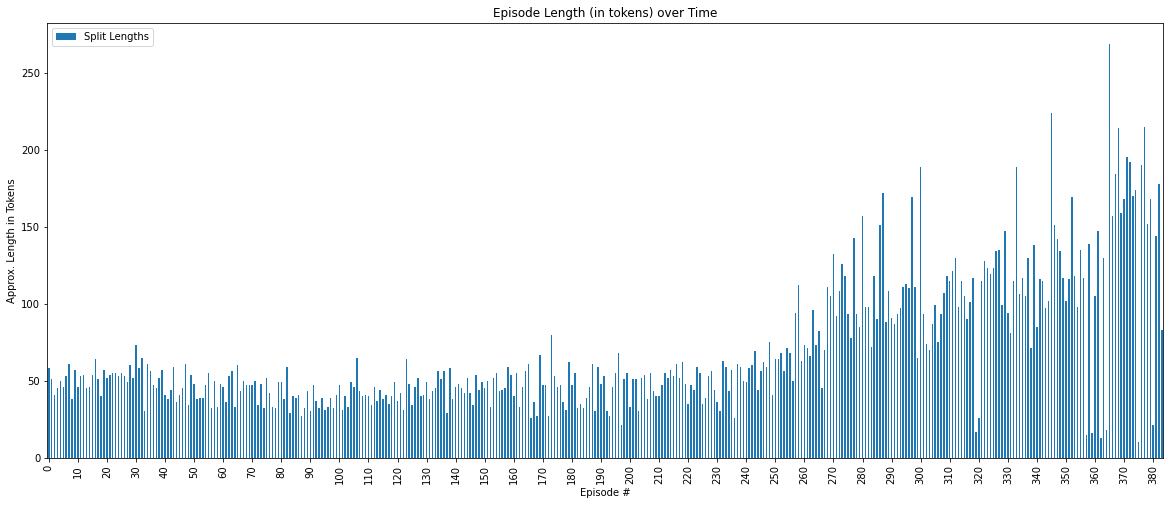

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

#helper function to capture the lengths of each split
def get_split_lengths(splits: List[List[str]], column_name: str='Split Lengths'):
    
    lengths = list(map(len, splits))
    return pd.DataFrame(lengths, columns=[column_name])

column_name = 'Split Lengths'
df = get_split_lengths(content_splits, column_name=column_name)
# reverse the order of the episode # to correctly show left to right chronological order
df.index = sorted(list(df.index), reverse=True)
# create plot
ax = df.iloc[::-1].plot.bar(y='Split Lengths', xlabel='Episode #', ylabel='Approx. Length in Tokens', title='Episode Length (in tokens) over Time', figsize=(20,8))
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

## Step 3 -->  Encode Text Chunks as Vectors
We are going to use the `all-MiniLM-L6-v2` variant because it's actually quite good out of the box and it also happens to be very fast (at embedding creation).  [Click here](https://www.sbert.net/docs/pretrained_models.html) for a comprehensive list of available pretrained SentenceTransformers (these are all available through the HuggingFace API).

Becuase we are building an Information Retrieval system that utilizes Vector Search, we're going to be most interested in the following numbers:
- Performance Semantic Search
- Speed (encoding speed)
- Model Size

Ultimately model selection comes down to your use case and the trade-off between performance and latency (and to a degree the size of the model on disk). Give yourself a chance to experiment with different embedding models to see how they can boost retrieval performance in your system.  When you're ready for that step head on over to the [Massive Text Embedding Benchmark (MTEB) Leaderboard](https://huggingface.co/spaces/mteb/leaderboard) where you can check out the latest state of the art embedding models.  The `all-MiniLM-L6-v2` ranks a lowly 47th on the Retrieval task.  

In [17]:
from sentence_transformers import SentenceTransformer
#define the model you want to use
model_name = 'sentence-transformers/all-MiniLM-L6-v2'
model = SentenceTransformer(model_name)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)

A quick glance at the model configuration shows us the following information:
- **Max sequence length:** (or input length) is 256 tokens.  The underlying model is a BERT model, so technically we could adjust this parameter to 512 tokens, however, because the model was trained on inputs of no greater than 256 tokens, we'll keep the default.
- **The embedding dimension:** (i.e. the output vector) is 384 dimensions.  Make sure not to confuse the `max_sequence_length` with the embedding dimesion.  The maximum sequence length is the maximum number of input tokens the model will process before truncating any text over that limit, and the emnbedding dim is the length of the output vector which always remains fixed in size.
- **Pooling Layer:** this model uses the mean token pooling strategy for creating a fixed sized embedding from all vector outputs.

We are going to work solely with the `model.encode` method for our text embedding creation.  There is a surprising amount of work being done under the hood with this function to include word tokenization, batching, GPU device setting, etc.
- `sentences`: accepts either a single string or a list of strings.  Very convenient.  This will allow us to enter all of the chunks from a single podcast episode at once, allowing for efficient processing and episode integrity.
- `batch_size`: under the hood the list of sentences in the input is batched.  Default is 32, so if your input was 128 sentences, then the model would translate that into 4 batches for processing.  DataLoader not needed.  If you are using Google Colab for this notebook, use the default setting.
- `convert_to_numpy`: default output is a numpy array. However, because Weaviate does not accept the np.array data type, we'll want to eventually convert these arrays into Python lists.
- `device`: set to either cpu or GPU (`"cuda:0"`) for single GPU.  If `None` the function will handle this step for you and choose the fastest option!

### Create Episode Embeddings:

#### We'll write a function that will vectorize each content split list (single episode) and then merge the text content and their vector representations into a single list of (text, vector) tuples.  Gather all episode lists into a single large list. We need to preserve the ordering of the text and their vector representations 


In [ ]:
def encode_content_splits(content_splits: List[List[str]],
                          model: SentenceTransformer,
                          device: str='cuda:0'
                          ) -> List[List[Tuple[str, np.array]]]:
    '''Encode content splits as vector embeddings from a list of content splits
     where each list of splits is a single podcast episode.'''

    text_vector_tuples = []
    for episode in tqdm(content_splits):
      text_vector_tuples.append(list(zip(episode,model.encode(episode))))

    return text_vector_tuples
  
text_vector_tuples = encode_content_splits(content_splits, model)

In [ ]:
#Unit Test to ensure you're on the right track
import unittest
from unitesting_utils import load_impact_theory_data

class TestEncodeContentSplits(unittest.TestCase):
    '''
    Unit test to ensure proper functionality of split_contents function
    '''

    def test_encode_content_splits(self):
        import tiktoken
        from numpy import ndarray
        from llama_index.text_splitter import SentenceSplitter
        from sentence_transformers import SentenceTransformer

        data = load_impact_theory_data()

        #get splits first
        subset = data[:3]
        chunk_size = 256
        chunk_overlap = 0
        encoding = tiktoken.encoding_for_model('gpt-3.5-turbo-0613')
        gpt35_txt_splitter = SentenceSplitter(chunk_size=chunk_size, tokenizer=encoding.encode, chunk_overlap=chunk_overlap)
        splits = split_contents(subset, gpt35_txt_splitter)

        #encode splits
        model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
        results = encode_content_splits(splits, model)

        #run assertion tests
        self.assertEqual(len(results), 3)
        self.assertEqual(len(results[0]), 83)
        self.assertEqual(len(results[1]), 178)
        self.assertEqual(len(results[2]), 144)
        self.assertTrue(isinstance(results, list))
        self.assertTrue(isinstance(results[0], list))
        self.assertTrue(isinstance(results[0][0], tuple))
        self.assertTrue(isinstance(results[0][0][0], str))
        self.assertTrue(isinstance(results[0][0][1], ndarray))
unittest.TextTestRunner().run(unittest.TestLoader().loadTestsFromTestCase(TestEncodeContentSplits))

Data not available at /content/impact_theory_data.json


  0%|          | 0/3 [00:00<?, ?it/s]

.
----------------------------------------------------------------------
Ran 1 test in 16.822s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

# Combining Metadata with Text/Vectors

#### *We will write a function that will combine episode metadata from the original corpus with their associated text/vector tuples*
#### We don't want our metadata to go to waste.  Now that we have our text/vector tuples grouped by episode, we can easily join all of that information together with each episode's metadata.

In [ ]:
def join_metadata(corpus: List[dict],
                  text_vector_list: List[List[Tuple[str, np.array]]],
                  content_field: str='content',
                  embedding_field: str='content_embedding'
                 ) -> List[dict]:
    '''
    Combine episode metadata from original corpus with text/vectors tuples.
    Creates a new dictionary for each text/vector combination.
    '''

    joined_documents = []

    for i, doc in enumerate(corpus):
      for j,tup in enumerate(text_vector_list[i]):

        d = {k:v for k,v in doc.items() if k!=content_field}

        video_id = doc['video_id']
        d['doc_id'] = f'{video_id}_{j}'
        d['content'] = tup[0]
        d['content_embedding'] = tup[1].tolist()

        joined_documents.append(d)

    return joined_documents

docs = join_metadata(data, text_vector_tuples)

In [ ]:
len(docs)

26448

## Step 4 --> Save

We've reached the final step in our data preparation phase. We should have 26,448 distinct documents and now ready to index those documents on **Weaviate host/database**. Before moving on to the indexing step, we'll want to store our dataset on disk.

The FileIO Class is a convenient wrapper that makes it easy to save data to disk in either json or [parquet format](https://towardsdatascience.com/demystifying-the-parquet-file-format-13adb0206705).  The choice is yours on which format to use, however, a note of caution: the json format will take up 3-4x more room on disk than parquet.

In [102]:
!pip install pyarrow --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [99]:
#instantiate FileIO Class
io = FileIO()
outpath = "impact-theory-minilmL6-256.parquet"
io.save_as_parquet(file_path=outpath, data=docs, overwrite=False)

2024-04-11 12:16:59.458 | INFO     | preprocessing:save_as_parquet:41 - DataFrame saved as parquet file here: impact-theory-minilmL6-256.parquet


In [103]:
#Verify that you can reload data
data_with_vectors = io.load_parquet(file_path=outpath)
# data_with_vectors[0]

Shape of data: (26448, 12)
Memory Usage: 2.42+ MB
